In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from matplotlib import pyplot as plt
data_folder = "gdrive/My Drive/FDL Project/Code/data"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv(data_folder + "/arxiv-dataset.csv")

In [ ]:
inputs = []
for abstract in df["abstract"]:
    inputs.append(abstract)

In [ ]:
class_names = sorted(set(df["categoryGroup"]))

In [ ]:
index = 0
labels = []
for name in class_names:
    for item in df["categoryGroup"]:
        if item == name:
            labels.append(index)
    index = index + 1

In [ ]:
# Number of available messages
data_card = len(inputs)
data_card

77208

In [ ]:
# Apply (the same) random shuffle to inputs and targets
rng = np.random.default_rng()
shuffler = rng.permutation(data_card)

In [ ]:
inputs = [inputs[i] for i in shuffler]
labels = [labels[i] for i in shuffler]

In [ ]:
# Specify the ratio of training-validation data and compute the corresponding number of elements
split_fraction = 0.8
N_train = int(split_fraction * data_card)
N_train

61766

In [ ]:
x_train = inputs[0:N_train]
y_train = labels[0:N_train]

In [ ]:
x_val = inputs[N_train:]
y_val = labels[N_train:]

In [ ]:
len(x_val)

15442

In [ ]:
# Convert targets to pure arrays (we will take care of x_train and x_val later)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
total_words = 20000
words_per_sentence = 200

In [ ]:
# Instantiate a vectorizer
vectorizer = TextVectorization(max_tokens=total_words, output_sequence_length=words_per_sentence)

In [ ]:
# Create the vocabulary in the vectorizer
vectorizer.adapt(x_train)
# Alternative for very large datasets: feed the corpus by batch
# text_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
# vectorizer.adapt(text_ds)

In [ ]:
# Inspect vocabulary (e.g. the first 4 words)
vectorizer.get_vocabulary()[0:5]

['', '[UNK]', 'the', 'of', 'and']

In [ ]:
# Test vectorizer (word-to-index vocabulary)
vectorizer([["the cat sat on the sofa"]])

<tf.Tensor: shape=(1, 200), dtype=int64, numpy=
array([[   2, 7768, 5707,   13,    2,    1,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [ ]:
# Apply vectorizer to all our data
x_train = vectorizer(x_train).numpy()
x_val = vectorizer(x_val).numpy()

In [ ]:
embeddings_index = {}
with open(data_folder + '/glove.6B.100d.txt',  encoding="utf8") as f:
  # For each text line
  for line in f:
    # Separate the word-string from the 100-dimensional-vector-string
    word, coeffs = line.split(maxsplit=1)
    # Convert 100-dimensional vector string into a proper floating point vector
    coeffs = np.fromstring(coeffs, "f", sep=" ")
    # Create a new dictionary entry
    embeddings_index[word] = coeffs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 100

In [ ]:
# Size of the matrix: 20002 rows x 100 dimensions
#   20000 words from our vocabulary + word separator + [unknown word]
#   100-dimensional representation from GloVe
embedding_matrix = np.zeros((total_words+2, embedding_dim))

# For each word in our vocabulary
for i, word in enumerate(vectorizer.get_vocabulary()):
    # Search corresponding embedding in GloVe,
    # and add it in the correct row of the embedding matrix
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    # else: words not found in embedding index will be all-zeros.

In [ ]:
# Transfer the embedding matrix to a Keras Embedding layer
embedding_layer = Embedding(
    total_words+2,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
# Define architecture
inputs = keras.Input(shape=(words_per_sentence,), dtype='int64')
x = embedding_layer(inputs)
x = keras.layers.Conv1D(128, 5, activation='relu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(8, activation='softmax')(x)
outputs = x
net = keras.Model(inputs, outputs)

In [ ]:
# Visualize the defined architecture
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 100)          2000200   
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                             

In [ ]:
# Compile neural model
net.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [ ]:
# Train
history = net.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_val, y_val))

In [ ]:
import json
json.dump(history.history, open(data_folder+"/history.json", 'w'))

In [ ]:
net.save(data_folder+"model.h5")

In [ ]:
model = keras.models.load_model(data_folder+"model.h5")

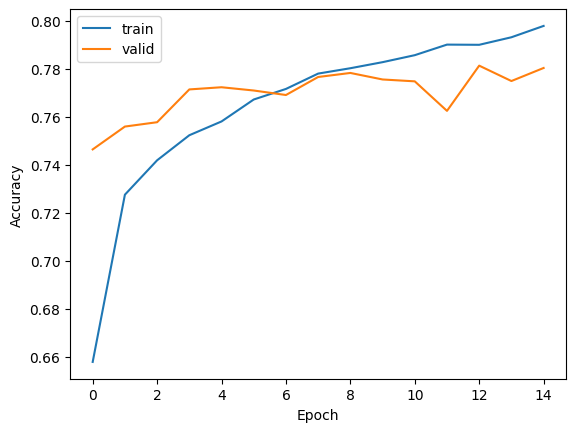

In [ ]:
# Visualize accuracy plots
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:
# Input as string
input_sentence = 'The article reveals the main theoretical approaches to the analysis and study of the phenomenon of corruption. Special attention is paid to the consideration of the index approach to the analysis of corruption.'

In [ ]:
# Input as vocabulary indices
input_vector = vectorizer(input_sentence)
input_vector

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([   2,  165, 1881,    2,  213,  218,  291,    7,    2,   60,    4,
         48,    3,    2,  953,    3, 5245,  379,  788,    9, 3581,    7,
          2, 1964,    3,    2,  528,   58,    7,    2,   60,    3, 5245,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

In [ ]:
# Embedded matrix and output probability distribution
output_probs = net.predict(input_vector[None, ...])
output_probs

1/1 [==============================] - 0s 168ms/step


array([[0.19875325, 0.04337637, 0.01040809, 0.06301948, 0.48741505,
        0.02562845, 0.13522995, 0.03616936]], dtype=float32)

In [ ]:
np.argmax(output_probs[0])

4

In [ ]:
# Selection of highest probabilty class
class_names[np.argmax(output_probs[0])]

'Physics'

In [ ]:
class_names

['Computer Science',
 'Economy',
 'Electrical Engineering and Systems Science',
 'Mathematics',
 'Physics',
 'Quantitative Biology',
 'Quantitative Finance',
 'Statistics']